In [218]:
import random
import csv
import scipy
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from matplotlib.ticker import NullFormatter
from sklearn.cluster import k_means
%matplotlib inline

In [219]:
gayser = pd.read_csv("gayser.csv", sep="\s+")

In [220]:
# 1a rescaling the data - function
def rescale_to_0_1 (data):
    top = np.max(data)
    bot = np.min(data)
    return (data - bot)/(top - bot)

In [221]:
# 1a rescaling the data - effectively
gayser['eruptions'] = rescale_to_0_1(gayser['eruptions'])
gayser['waiting'] = rescale_to_0_1(gayser['waiting'])

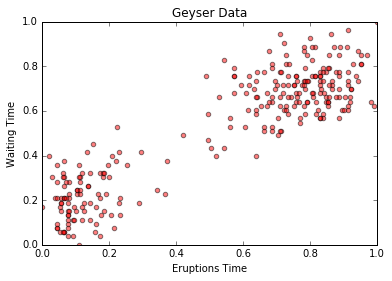

In [252]:
plt.scatter(gayser['eruptions'], gayser['waiting'], c='r', alpha=0.5)
plt.title('Geyser Data')
plt.xlabel('Eruptions Time')
plt.ylabel('Waiting Time')
plt.axis([0,1,0,1])
plt.show()

In [223]:
data_set = np.asarray(gayser)

In [224]:
def initialize(X):
    p = len(X[0])    
    weight = [.5,.5]
    mean = X[np.random.choice(p, 2, False)]
    cov = np.zeros((2,p,p))
    for j in range(2):
        for i in range(p):
            cov[j,i,i] = 0.5+random.random()*10

    return weight,mean,cov

In [225]:
pis,mus,sigmas = random_init(data_set)

In [226]:
def E_step(X,m,n,weight,means,cov):
        resp = np.zeros((m,n))
        for j in range(m):
            for i in range(n):
                resp[j,i] = weight[j] * mvn(means[j],cov[j]).pdf(X[i])
        resp /= resp.sum(0)
        return resp

In [227]:
def M_step (m,n,resp):
        weight = np.zeros(m)
        for j in range(m):
            for i in range(n):
                weight[j] += resp[j,i]
        weight /= n
        return weight

In [228]:
def sigmas_calc(m,p,n,X,mean,resp):
    cov = np.zeros((m,p,p))
    for j in range(m):
        for i in range(n):
            Y = np.reshape(X[i] - mean[j], (2,1))
            cov[j] += resp[j, i] * np.dot(Y, Y.T)
        cov[j] /= resp[j,:].sum()
    return cov

In [229]:
def mus_calc (X, resp, m, p, n):
    mean = np.zeros((m, p))
    for j in range(m):
        for i in range(n):
            mean[j] += resp[j, i] * X[i]
        mean[j] /= resp[j, :].sum()
    return mean

In [230]:
def log_likelihood_calc(n, m, weight, mean, cov, X):
    log_likelihood = 0.0
    for i in range(n):
        sum_to_log = 0
        for j in range(m):
            sum_to_log += weight[j] * mvn(mean[j], cov[j]).pdf(X[i])
    log_likelihood += np.log(sum_to_log)
    return log_likelihood

In [231]:
def EM_steps(X, size, mean, cov, tolerance=0.00000001, maxiter=100):
    
    n = len(X)
    p = len(X[0]) 
    m = len(size)
    
    ll_old = 0.0
    iter_count = 0
    mu_vector = []
    mu_vector.append(mean)
    
    for i in range(maxiter):
        responsibility = E_step(X, m, n, size, mean, cov)
        size = M_step(m,n,responsibility)
        mu_vector.append(mus_calc(X, responsibility, m, p, m))
        cov = sigmas_calc(m, p, n, X, mean, responsibility)
        ll_new = log_likelihood_calc(n, m, size, mean, cov, X)
        iter_count += 1

        if np.abs(ll_new - ll_old) < tolerance:
            break
        else:
            ll_old = ll_new
            
    mu_vector = np.array(mu_vector)

    return iter_count,mu_vector,size, mean, cov

In [232]:
iter_count,mu_vector,pis,mus,sigmas = EM_steps(data_set, pis, mus, sigmas)

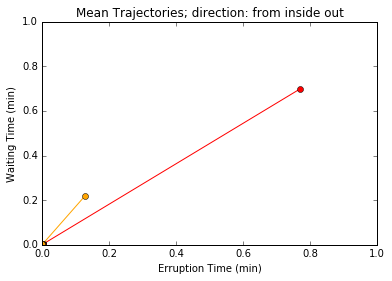

In [254]:
plt.title("Mean Trajectories; direction: from inside out")
plt.xlabel('Erruption Time (min)')
plt.ylabel('Waiting Time (min)')
plt.axis([0,1,0,1])
data0 = mu_vector[:,0]
data1 = mu_vector[:,1]
plt.plot(data0[:,0], data0[:,1], '-o', color='red')
plt.plot(data1[:,0], data1[:,1], '-o', color='orange')
plt.show()

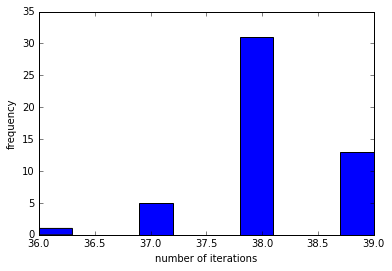

In [240]:
iter_count = 0
iteration = []
for i in range(50):
    pis,mus,sigmas = initialize(data_set)
    iter_count = EM_steps(data_set, pis, mus, sigmas)[0]
    iteration.append(iter_count)
    
plt.xlabel("number of iterations")
plt.ylabel("frequency")
plt.hist(iteration,bins=10)
plt.show()

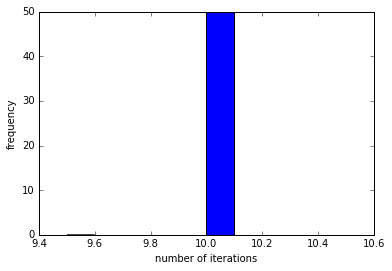

In [250]:
K_iter_count = 0
K_iteration = []
for i in range(50):
    pis,mus,sigmas = kmeans_run(data_set)
    K_iter_count, mu_vector, pis, mus, sigmas = EM_steps(data_set, pis, mus, sigmas)
    K_iteration.append(K_iter_count)
    
plt.xlabel("number of iterations")
plt.ylabel("frequency")
plt.hist(K_iteration,bins=10)
plt.show()

In [246]:
def kmeans_assist(cluster, mean, cov):
    for i in range(len(cluster)):
        y = np.reshape(cluster[i]-mean, (2,1))
        cov += np.dot(y, y.T)
    cov /= len(cluster)
    return cov

In [247]:
from sklearn.cluster import k_means

def kmeans_run(X):
    clusters = [[],[]]
    means = []
    sigmas = []
    
    y = k_means(X,2)[1]
    for i in range(len(y)):
        clusters[y[i]].append(X[i]) #use the mean of the cluster as your first guess
    
    pi = float(len(clusters[0]))
    pi /= float(len(y))
    pis = [pi,1-pi] 

    for i in range(2):
        cluster = clusters[i]
        mean = np.average(cluster,axis=0) 
        means.append(mean)
        cov = np.zeros((2,2))
        sigmas.append(kmeans_assist(cluster, mean, cov))

    return pis,means,sigmas